## Data-Analyst-Agent - PoC
Here, we will create the Data-Analyst agent. Given a single relevant table, it's task will be to attempt to answer the user's question.

The data-analyst agent will have access to Python-shell to run commands and perform analysis to learn insights about the data w.r.t the user's question.

We will use `LangGraph` to build this custom tool-calling agent.

Some desired features of the Data-Analyst agent:
- It should be able to write Python queries
- It should be able to run Python queries
- It should be able to import relevant python libraries (like Pandas, Numpy, JSON, etc.) required to run the code.
- The analysis it does should not include any visualisation, only the written descriptive statistics are required (since the LLM will be able to see and understand textual output only)
- It should be able to handle any runtime errors faced during Python execution, and take corrective actions by re-writing the python-script and attempting to run it again
- The output generated after running the Python queries should be used to gradually build the context, over multiple calls to Python-execution tool (if required)
- Once the agent "thinks" it has enough context to answer the question, it should attempt to answer the question citing only the statistics from the table
- If there's no relevant context, the agent should cease running and reply with something like - "*this table does not contain enough relevant information to answer your question ...*"

Let's get started.


graphstate:
    - messages: list
    - context: list
    - table_id: str
    - 

In [1]:
import os
import io
import sys
import json
import traceback
import regex as re
import pandas as pd
from pyjstat import pyjstat
from textwrap import dedent
from pyjstat import pyjstat
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Dict, List, Any, Literal, Annotated

from langgraph.types import Command
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, AIMessage, ToolMessage
from langgraph.prebuilt import InjectedState
from langchain_core.tools import tool, InjectedToolCallId

In [2]:
from pathlib import Path
import os

root = Path().absolute().parents[1]
os.chdir(str(root))

In [3]:
llm_low = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_med = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_high  = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [4]:
def _run_python_safely(code: str) -> Dict[str, Any]:
    """
    Minimal sandbox runner. In production: isolate with subprocess, container, time & mem limits.
    Returns {"stdout": str, "error": {"type":, "message":, "trace":}} on failure.
    """
    stdout_capture = io.StringIO()
    old_stdout, old_stderr = sys.stdout, sys.stderr
    sys.stdout = stdout_capture
    sys.stderr = stdout_capture  # co-mingle
    globals_dict = {"__name__": "__main__"}
    try:
        exec(code, globals_dict, globals_dict)
        out = stdout_capture.getvalue()
        return {"stdout": out}
    except Exception as e:
        err = {"type": e.__class__.__name__, "message": str(e), "trace": traceback.format_exc()}
        return {"stdout": stdout_capture.getvalue(), "error": err}
    finally:
        sys.stdout, sys.stderr = old_stdout, old_stderr

@tool(name_or_callable="python_code_executor", parse_docstring=True)
def python_code_executor(
    code: str,
    description: str,
    state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """
    Executes the given Python code and returns the output.
    
    Args:
        code (str): The Python code to execute.
        description (str): A short description of the code being executed.
    
    Returns:
        str: The output of the executed code.
    """
    print("Executing code in python_code_executor: ", description)
    result = _run_python_safely(code)
    print("Result from python_code_executor: ", result['stdout'])

    if 'error' in result:
        return Command(
            update={
                "scratchpad": [
                    ToolMessage(
                        content=f"Error executing code: {result['error']}",
                        tool_call_id=tool_call_id,
                        name="python_code_executor"
                    )
                ],
            }
        )
    

    return Command(
        update={
            "scratchpad": [
                ToolMessage(
                    content=result['stdout'],
                    # content="Context updated with required analysis.",
                    tool_call_id=tool_call_id,
                    name="python_code_executor"
                )
            ],
        }
    )

TOOLS = [python_code_executor]

llm_med_with_code_exec_tool = llm_med.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])
llm_high_with_code_exec_tool = llm_high.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])

In [ ]:
class State(TypedDict):
    """State for the analyst agent."""
    scratchpad: Annotated[list[BaseMessage], add_messages] = Field(default=[], description="The scratchpad for the agent.")
    context: str = Field(default=None, description="The context for the agent to use.")
    iters: int = Field(default=0, description="The number of iterations the agent has gone through.")
    sub_question: str = Field(description="The question asked by the user.")
    table_id: str
    # csv_fp: str = Field(default="", description="The file path to the CSV file containing the CSO data.")
    # code: str = Field(default="", description="The python code to run.")


In [81]:
from src.helpers.json_stat_archive_db import JSONStatArchiveDB

cso_archive_reader = JSONStatArchiveDB(compression_level=12)

In [82]:
SYSTEM_PROMPT_ANALYST = dedent(
    f"""\
        # ROLE: I am a Data Analyst Agent that has access to Python-shell tool/function - `python_code_executor(code: str, description: str)`.

        # INSTRUCTIONS:
            - I call the `python_code_executor` tool to analyse the data.
            - Once I feel I know enough, I give a crisp and concise answer to the user's question.

        # NOTE:
            - The python-script should import necessary libraries (pandas, numpy, os, pathlib, etc) to read the CSV file and perform data manipulation 
            - The python-script use `print` statements for printing any statistics that you need to fetch.
            - In a single tool-call to `python_code_executor`, I ask for a single statistic to be fetched.
            - I keep the commentary limited in this step.
            - Once I have enough statistics to answer the user's question, I give a crisp and concise answer to user's question, with proper data backing it up.
        
        # WARNINGS:
            - For tool-calls to `python_code_executor` tool, only send the python code as `code` parameter
            - Do not include any visualizations or plots in the code.
            - In case I get reported back with any errors in executing the python code, I should make necessary corrections and call the python_code_executor tool to re-run the code.
        
        # TIPS:
            - For high cardinality columns, consider using simple keyword based filtering (like `str.contains('abc|xyz')`). Also consider items / categories related to said keywords.
    """
)
def _create_table_analysis(df: pd.DataFrame, table_id: str) -> dict:
    """
    Analyzes the table and returns a dictionary with the analysis results.

    Args:
        df (pd.DataFrame): The DataFrame containing the CSO data.

    Returns:
        dict: A dictionary containing the analysis results.
    """
    csv_fp = f"cache/{table_id}.csv"
    try:
        table_shape = df.shape
        table_sample = pd.concat([df.head(5), df.tail(5)]) if len(df) > 10 else df
        
        table_info_df = pd.DataFrame({
            "columns": df.columns,
            "dtypes": [str(df[col].dtype) for col in df.columns],
            "nunique": [df[col].nunique() if df[col].nunique() <= 50 else '>50' for col in df.columns],
            "nulls": [df[col].isnull().sum() for col in df.columns]
        })

        context_list = [
            "CONTEXT:",
            f"- **CSV File Path**: {csv_fp}",
            f"- **Table Shape**: {table_shape}",
            "- **Table Info**:",
            table_info_df.to_string(index=False),
            "- **Table Sample (first and last 5 rows)**:",
            table_sample.to_string(index=False),
        ]

    except Exception as e:
        context_list = None

    return context_list

def analyst_agent(state: State) -> str:
    """
    The analyst agent has access to the Python-Shell tool and uses it answer the user query by analysing the data available in context.

    Args:
        state (State): The state containing the messages and other data.
    
    Returns:
        str: The response from the analyst agent.
    """
    sub_question = state["sub_question"]
    old_messages = state["scratchpad"]
    system_prompt = SYSTEM_PROMPT_ANALYST
    iters = state["iters"]
    table_id = state["table_id"]
    iters += 1

    csv_save_dir = "cache/"
    csv_fp = csv_save_dir + f"{table_id}.csv"

    # check if "<table_id>.csv" exists. If not, read the pyjstat-file from artifacts and save the DataFrame as "<table_id>.csv"
    if not os.path.exists(csv_fp):
        for _, ds, _ in cso_archive_reader.read("artifacts/cso_bkp/cso_archive/jsonstat_archive.sqlite", table_id=table_id, with_labels=True):
            df: pd.DataFrame = pyjstat.from_json_stat(ds)[0]
        df.to_csv(csv_fp, index=False)

    if state.get("context", None) is None:
        df = pd.read_csv(csv_fp)
        context_list = _create_table_analysis(df, table_id)
        context = "\n".join(context_list) if context_list else "No context available."
    else:
        context = state["context"]

    msgs = [
        SystemMessage(content=system_prompt, name="analyst_agent"),
        SystemMessage(content=context, name="analyst_agent"),
        HumanMessage(content=sub_question, name="analyst_agent"),
    ] + old_messages
    
    if iters <= 10:
        print("Running data-analyst agent...")
        res = llm_med_with_code_exec_tool.invoke(msgs)
    else:
        print("Stopping tool-calls as max-iterations reached. Generating final response...")
        res = llm_med.invoke(msgs)
        return {"scratchpad": [res], "iters": iters, "context": context}
    
    if isinstance(res, AIMessage):
        return {"scratchpad": [res], "iters": iters, "context": context}
    else:
        res = AIMessage("Error generating code.")
        return {"scratchpad": [res], "iters": iters, "context": context}


In [83]:
def has_tool_calls(msg: AIMessage) -> bool:
    """
    Check if the AIMessage has tool calls.
    
    Args:
        msg (AIMessage): The AI message to check.
    
    Returns:
        bool: True if the message has tool calls, False otherwise.
    """
    return getattr(msg, "tool_calls", None) is not None or \
           bool(getattr(msg, "additional_kwargs", {}).get("function_call") or \
                getattr(msg, "additional_kwargs", {}).get("tool_calls"))


def custom_tools_condition(state: State) -> bool:
    """
    Route the LLM based on tool calls in the last message.
    
    Args:
        state (State): The current state of the graph.
    
    Returns:
        str: "tools" if the last message has tool calls, "end" otherwise.
    """
    messages_key = "scratchpad"
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

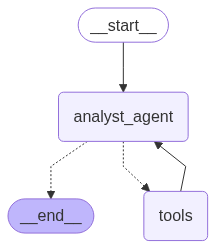

In [84]:
tool_node = ToolNode(TOOLS, messages_key="scratchpad")

analyst_graph_builder = StateGraph(State)

analyst_graph_builder.add_node("analyst_agent", analyst_agent)
analyst_graph_builder.add_node("tools", tool_node)

analyst_graph_builder.add_edge(START, "analyst_agent")
analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"__end__": END, "tools": "tools"})
# analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"end": END, "tools": "tools"})
analyst_graph_builder.add_edge("tools", "analyst_agent")

analyst_graph = analyst_graph_builder.compile()
analyst_graph

In [ ]:
question = "QUESTION: Give me the breakdown of renewable energy resources as a percentage share and absolute numbers in 2022 in ireland."
question = "QUESTION: How's the energy production in ireland over the years? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: How's the wind energy production over the years?"
question = "QUESTION: Did the Ukraine war have any impact on the energy production in ireland??"
# question = "QUESTION: How has nuclear energy done over the years in ireland?"
# question = "QUESTION: What's the impact of climate change on energy production in ireland?"
# question = "QUESTION: How's the energy production in ireland over 2021-2025? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: What's the total agricultural area in Ireland?"
question = "detailed statistics on cosmetics, toileteries and related items production in prodcom data for ireland"
question = "detailed statistics on lignin based products and related items production in prodcom data for ireland"



table_id = "PCA23"

res = analyst_graph.invoke(
    {
        "sub_question": question,
        "table_id": table_id,
    },
    # config={"recursion_limit": 1}
)
print("\n\nFINAL OUTPUT:\n", res["scratchpad"][-1].content)

Running data-analyst agent...
Executing code in python_code_executor:  Filtering for 'lignin' in the Product column to find lignin based products and their total value.
Result from python_code_executor:  Number of lignin related products: 0
Total value of lignin related products: 0.0
Unique products containing 'lignin':
[]

Running data-analyst agent...
Executing code in python_code_executor:  Filtering for 'wood pulp' in the Product column to find related products and their total value.
Result from python_code_executor:  Number of wood pulp related products: 10
Total value of wood pulp related products: 0.0
Unique products containing 'wood pulp':
['17111100 Chemical wood pulp, dissolving grades (kg 90% sdt)'
 '17111200 Chemical wood pulp, soda or sulphate, other than dissolving grades (kg 90% sdt)'
 '17111300 Chemical wood pulp, sulphite, other than dissolving grades (kg 90% sdt)'
 '17111400 Mechanical wood pulp; semi-chemical wood pulp; pulps of fibrous cellulosic... (kg 90% sdt)'
 '

In [79]:
res

{'scratchpad': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_code_executor', 'arguments': '{"code": "\\nimport pandas as pd\\ndf = pd.read_csv(\'cache/PCA23.csv\')\\nlignin_products_df = df[df[\'Product\'].str.contains(\'lignin\', case=False)]\\nprint(f\\"Number of lignin related products: {len(lignin_products_df)}\\")\\nprint(f\\"Total value of lignin related products: {lignin_products_df[\'value\'].sum()}\\")\\nprint(f\\"Unique products containing \'lignin\':\\\\n{lignin_products_df[\'Product\'].unique()}\\")\\n", "description": "Filtering for \'lignin\' in the Product column to find lignin based products and their total value."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--68f72ae2-4c49-49c5-890b-6a5018bc7495-0', tool_calls=[{'name': 'python_code_executor', 'args': {'code': '\nimport pandas as pd\ndf = pd.read_csv(\'cache/PC

In [48]:
res["scratchpad"]

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_code_executor', 'arguments': '{"description": "Check the number of unique products related to cosmetics and toiletries.", "code": "\\nimport pandas as pd\\ndf = pd.read_csv(\'cache/PCA23.csv\')\\nfiltered_df = df[df[\'value\'] != -99999999.0]\\ncosmetics_toiletries_df = filtered_df[\\n    filtered_df[\'Product\'].str.contains(\\n        \'cosmetic|toilet|perfume|soap|shampoo|lotion|make-up|fragrance|dentifrice|oral hygiene|hair|skin|polish\',\\n        case=False, na=False\\n    )\\n]\\nprint(cosmetics_toiletries_df[\'Product\'].nunique())\\n"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--707d788e-1c71-453e-b6ee-0709a5de8be4-0', tool_calls=[{'name': 'python_code_executor', 'args': {'description': 'Check the number of unique products related to cosmetics and toiletries.', 'code': "\n

In [49]:
print(res["scratchpad"][0].tool_calls[0]['args']['description'])
print(res["scratchpad"][0].tool_calls[0]['args']['code'])


Check the number of unique products related to cosmetics and toiletries.

import pandas as pd
df = pd.read_csv('cache/PCA23.csv')
filtered_df = df[df['value'] != -99999999.0]
cosmetics_toiletries_df = filtered_df[
    filtered_df['Product'].str.contains(
        'cosmetic|toilet|perfume|soap|shampoo|lotion|make-up|fragrance|dentifrice|oral hygiene|hair|skin|polish',
        case=False, na=False
    )
]
print(cosmetics_toiletries_df['Product'].nunique())



In [50]:
print(res["scratchpad"][1].content)

82



In [27]:
print("# ", res["scratchpad"][2].tool_calls[0]['args']['description'])
print(res["scratchpad"][2].tool_calls[0]['args']['code'])

#  Identify unique product names related to beauty makeup and skincare.
import pandas as pd
df = pd.read_csv("cache/PCA23.csv")
beauty_skincare_products = df[df['Product'].str.contains('beauty|makeup|skin care|cosmetic|perfume|toiletries|shampoo|soap|dentifrice|deodorant', case=False, na=False)]
print(beauty_skincare_products['Product'].unique())



In [28]:
print(res["scratchpad"][3].content)

['13991900 Powder-puffs and pads for the application of cosmetics or toilet preparations (p/st)'
 '20412020 Anionic organic surface-active agents (excluding soap) (kg)'
 '20412030 Cationic organic surface-active agents (excluding soap) (kg)'
 '20412050 Non-ionic organic surface-active agents (excluding soap) (kg)'
 '20412090 Organic surface-active agents (excluding soap, anionic, cationic, non-ionic) (kg)'
 '20413120 Soap and organic surface-active products in bars, etc., n.e.c. (kg)'
 '20413150 Soap in the form of flakes, wafers, granules or powders (kg)'
 '20413180 Soap in forms excluding bars, cakes or moulded shapes, paper, wadding, felt and... (kg)'
 '20413240 Surface-active preparations, whether or not containing soap, p.r.s. (excluding... (kg)'
 '20413250 Washing preparations and cleaning preparations, with or without soap, p.r.s.... (kg)'
 '20413260 Surface-active preparations, whether or not containing soap, n.p.r.s. (excluding... (kg)'
 '20413270 Washing preparations and clea

In [29]:
print("# ", res["scratchpad"][4].tool_calls[0]['args']['description'])
print(res["scratchpad"][4].tool_calls[0]['args']['code'])

#  Calculate the total production value for beauty, makeup, and skincare products in 2023.
import pandas as pd
df = pd.read_csv("cache/PCA23.csv")
beauty_skincare_products_keywords = ['13991900 Powder-puffs and pads for the application of cosmetics or toilet preparations (p/st)', '20412020 Anionic organic surface-active agents (excluding soap) (kg)', '20412030 Cationic organic surface-active agents (excluding soap) (kg)', '20412050 Non-ionic organic surface-active agents (excluding soap) (kg)', '20412090 Organic surface-active agents (excluding soap, anionic, cationic, non-ionic) (kg)', '20413120 Soap and organic surface-active products in bars, etc., n.e.c. (kg)', '20413150 Soap in the form of flakes, wafers, granules or powders (kg)', '20413180 Soap in forms excluding bars, cakes or moulded shapes, paper, wadding, felt and... (kg)', '20413240 Surface-active preparations, whether or not containing soap, p.r.s. (excluding... (kg)', '20413250 Washing preparations and cleaning preparatio

In [31]:
print(res["scratchpad"][5].content)

Total production value for beauty, makeup, and skincare products: -2366379904.0



In [32]:
print("# ", res["scratchpad"][6].tool_calls[0]['args']['description'])
print(res["scratchpad"][6].tool_calls[0]['args']['code'])

#  Calculate the total production value for beauty, makeup, and skincare products in 2023, excluding invalid values.
import pandas as pd
df = pd.read_csv("cache/PCA23.csv")
beauty_skincare_products_keywords = ['13991900 Powder-puffs and pads for the application of cosmetics or toilet preparations (p/st)', '20412020 Anionic organic surface-active agents (excluding soap) (kg)', '20412030 Cationic organic surface-active agents (excluding soap) (kg)', '20412050 Non-ionic organic surface-active agents (excluding soap) (kg)', '20412090 Organic surface-active agents (excluding soap, anionic, cationic, non-ionic) (kg)', '20413120 Soap and organic surface-active products in bars, etc., n.e.c. (kg)', '20413150 Soap in the form of flakes, wafers, granules or powders (kg)', '20413180 Soap in forms excluding bars, cakes or moulded shapes, paper, wadding, felt and... (kg)', '20413240 Surface-active preparations, whether or not containing soap, p.r.s. (excluding... (kg)', '20413250 Washing preparatio

In [51]:
import pandas as pd


df = pd.read_csv('cache/PCA23.csv')
filtered_df = df[df['value'] != -99999999.0]
cosmetics_toiletries_df = filtered_df[
    filtered_df['Product'].str.contains(
        'cosmetic|toilet|perfume|soap|shampoo|lotion|make-up|fragrance|dentifrice|oral hygiene|hair|skin|polish',
        case=False, na=False
    )
]
cosmetics_toiletries_df['Product'].unique()

array(['10114200 Raw hides and skins of bovine or equine animals, whole (except those linked to... (p/st)',
       '10114400 Skins of sheep or lambs (p/st)',
       '10114500 Raw hides and skins of goats or kids but not tanned, fresh or preserved (p/st)',
       '10611230 Semi-milled or wholly milled (bleached) rice, whether or not polished or glazed (kg)',
       '13102300 Noils of wool or fine animal hair (kg)',
       '13105010 Yarn of carded wool or fine animal hair, n.p.r.s. (kg)',
       '13105030 Yarn of combed wool or fine animal hair, n.p.r.s. (kg)',
       '13301220 Bleaching of woven fabrics of wool, fine or coarse animal hair or horsehair (-)',
       '13301320 Dyeing of woven fabrics of wool, fine or coarse animal hair or horsehair (-)',
       '13921130 Blankets and travelling rugs of wool or fine animal hair (excluding electric... (p/st)',
       '13921430 Toilet linen and kitchen linen, of terry towelling or similar terry fabrics of... (kg)',
       '13921450 Woven toil

In [56]:
cosmetics_toiletries_df[cosmetics_toiletries_df['value'] > 0]

,Statistic,Year,Product,value
91,Prodcom Sales 2023,2023,10114200 Raw hides and skins of bovine or equi...,28481.0
93,Prodcom Sales 2023,2023,10114400 Skins of sheep or lambs (p/st),485.0
574,Prodcom Sales 2023,2023,13921130 Blankets and travelling rugs of wool ...,3605.0
1483,Prodcom Sales 2023,2023,20412020 Anionic organic surface-active agents...,13820.0
1491,Prodcom Sales 2023,2023,20413250 Washing preparations and cleaning pre...,3333.0
1509,Prodcom Sales 2023,2023,"20421500 Beauty, make-up and skin care prepara...",1096.0
1517,Prodcom Sales 2023,2023,20421930 Organic surface-active products and p...,245.0
1521,Prodcom Sales 2023,2023,20421990 Other personal preparations (perfumer...,2270.0
4066,Prodcom Sales 2023 (Volume),2023,10114200 Raw hides and skins of bovine or equi...,22100106.0
4068,Prodcom Sales 2023 (Volume),2023,10114400 Skins of sheep or lambs (p/st),536496.0


In [38]:
beauty_skincare_data[beauty_skincare_data['value'] != -99999999.0]

,Statistic,Year,Product,value
655,Prodcom Sales 2023,2023,13991900 Powder-puffs and pads for the applica...,0.0
1483,Prodcom Sales 2023,2023,20412020 Anionic organic surface-active agents...,13820.0
1485,Prodcom Sales 2023,2023,20412050 Non-ionic organic surface-active agen...,0.0
1488,Prodcom Sales 2023,2023,"20413150 Soap in the form of flakes, wafers, g...",0.0
1491,Prodcom Sales 2023,2023,20413250 Washing preparations and cleaning pre...,3333.0
1503,Prodcom Sales 2023,2023,20421150 Perfumes (l),0.0
1508,Prodcom Sales 2023,2023,"20421400 Powders, whether or not compressed, f...",0.0
1509,Prodcom Sales 2023,2023,"20421500 Beauty, make-up and skin care prepara...",1096.0
1510,Prodcom Sales 2023,2023,20421630 Shampoos (-),0.0
1514,Prodcom Sales 2023,2023,"20421850 Dentifrices (including toothpaste, de...",0.0
